# (06) DOVES—LapConv—0

**Motivation**: Laplace + DOVES + Conv encoder. ```prior_fit = True```. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'laplace'

## Archi: ```<Conv|Lin>```

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'conv+b|lin')
cfg_vae['fit_prior'] = True

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'DOVES', 'n_ch': 32, 'n_latents': 512, 'latent_act': None, 'fit_prior': True, 'enc_type': 'conv', 
'dec_type': 'lin', 'enc_bias': True, 'dec_bias': False}

Trainer:
{'temp_anneal_portion': 1.0, 'temp_anneal_type': 'exp', 'temp_start': 1.0, 'temp_stop': 1.0, 'lr': 0.005, 
'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  LaplaceVAE |  1.5 Mil   |
|     ---     |    ---     |
|     stem    |    352     |
|     enc     |  1.2 Mil   |
|    fc_enc   |  132.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

laplace_None_prior-fit_DOVES_z-512_k-32_<conv+b|lin>
mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(1:exp-1)_gr(500)_(2024_05_06,14:53)

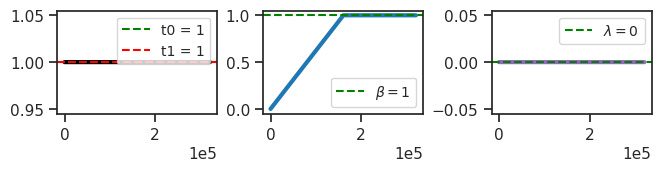

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
vae.fc_dec.bias, vae.fc_enc.bias.shape

(None, torch.Size([1024]))

In [7]:
vae.loc.requires_grad

True

### Train

In [8]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3000, avg loss: 158.553232: 100%|█████████████████████| 3000/3000 [2:29:14<00:00,  2.98s/it]


### Loss vld (freeze)

In [9]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 107.908554, 'kl': 50.816753, 'kl_diag': 0.09871967, 'tot': 158.72531}

In [10]:
### Was: categorical with prior fit

{'mse': 165.39445, 'kl': 5.4255557, 'kl_diag': 5.414346, 'tot': 170.82}

In [26]:
### Was: fixed prior

{'mse': 165.01498, 'kl': 5.632016, 'kl_diag': 5.6216135, 'tot': 170.647}

{'mse': 134.10709, 'kl': 28.86082, 'kl_diag': 0.056184433, 'tot': 162.96791}

{'mse': 133.72597, 'kl': 28.916742, 'kl_diag': 0.05594784, 'tot': 162.64272}

{'mse': 132.80032, 'kl': 29.794188, 'kl_diag': 0.05768895, 'tot': 162.59451}

### Plot enc/dec weights

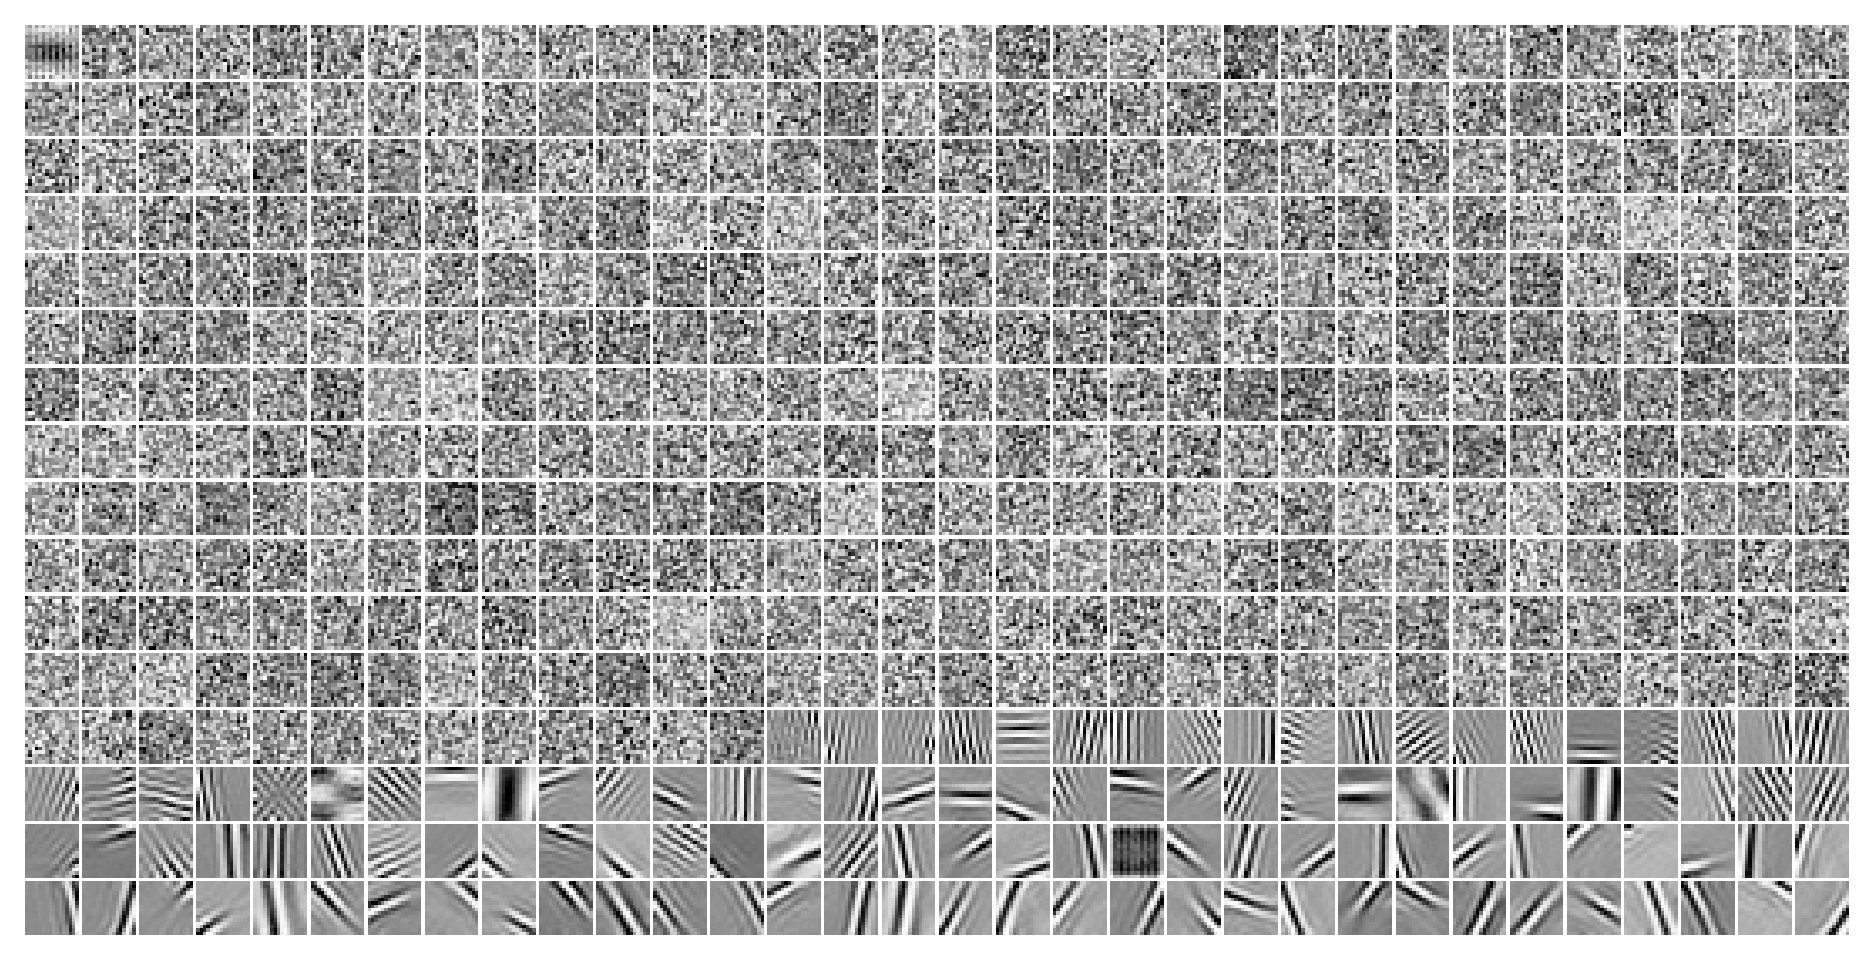

In [10]:
vae.show(dpi=250, order=np.argsort(flatten_np(etc['scale'], start_dim=1).mean(0)));

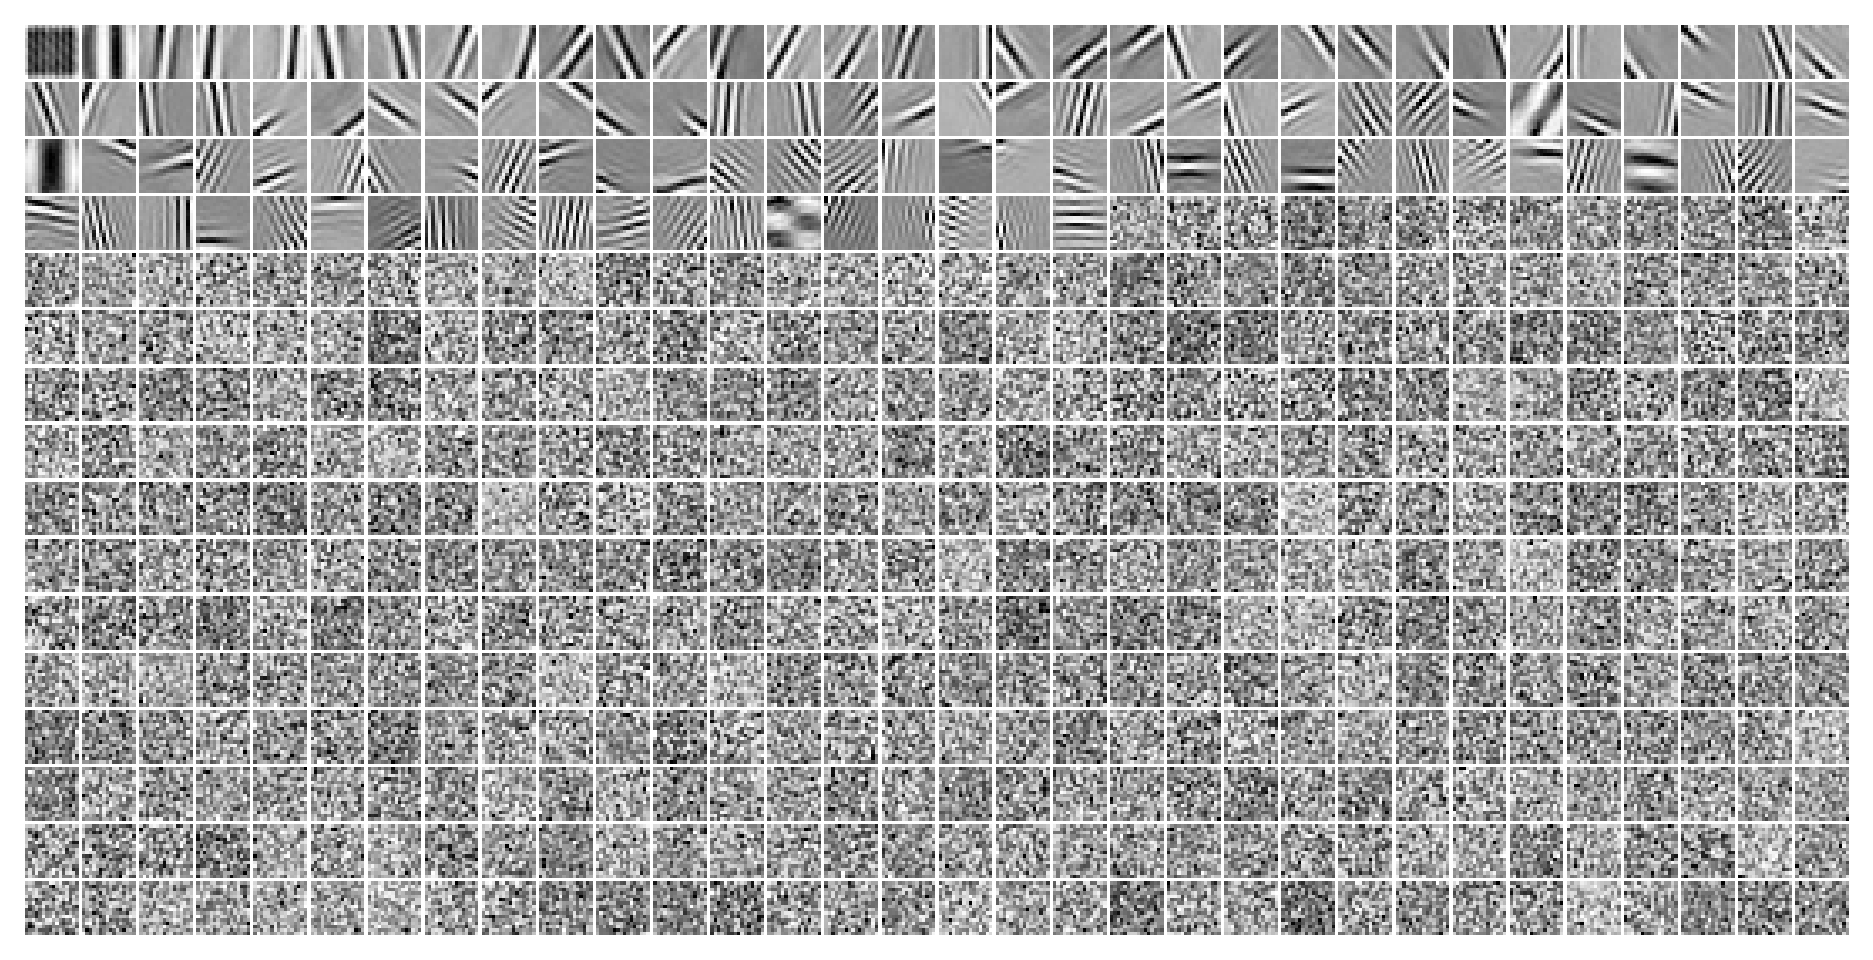

In [12]:
### Was: fit_prior = False

### Some more distributions

In [11]:
tr.model.temp, tr.cfg.kl_beta

(tensor(1., device='cuda:0'), 1.0)

In [12]:
from figures.imgs import plot_weights

In [13]:
dead_thres = 0.1

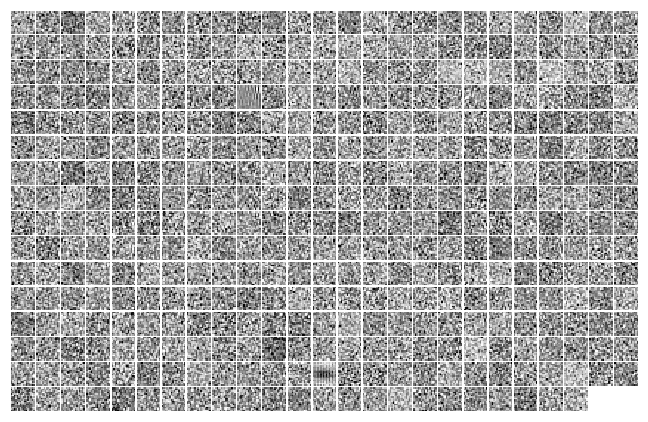

In [14]:
try:
    ind = np.where(loss['kl_diag'] < dead_thres)[0]
    plot_weights(vae.fc_dec.weight.data.T.reshape(-1, 16, 16)[ind], nrows=16, dpi=110);
except ValueError:
    pass

In [15]:
try:
    ind = np.where(tonp(vae.log_scale.squeeze()) > 1)[0]
    plot_weights(vae.fc_dec.weight.data.T.reshape(-1, 16, 16)[ind], nrows=1, dpi=15);
except ValueError:
    pass

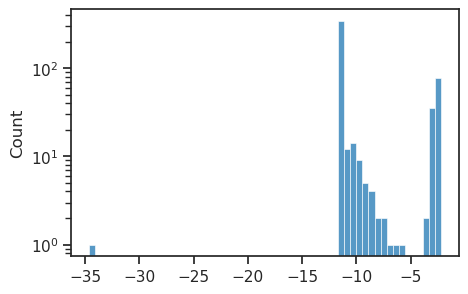

In [20]:
ax = sns.histplot(tonp(vae.log_scale.squeeze()))
ax.set(yscale='log');

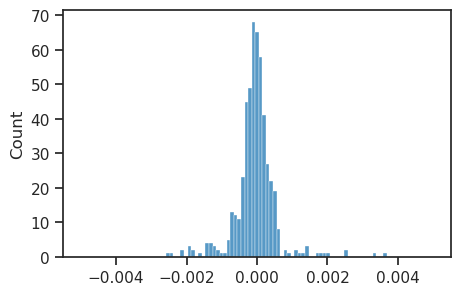

In [30]:
sns.histplot(tonp(vae.loc.squeeze()), bins=np.linspace(-0.005, 0.005, 100));

## Loggabor analysis

In [31]:
dead_thres = 0.1
dead = loss['kl_diag'] < dead_thres

In [32]:
from analysis.loggabor import fit_loggabor
from figures.theta import plot_theta
from figures.imgs import plot_weights

In [33]:
results = fit_loggabor(tr, verbose=True)

  5%|▌           | 25/512 [00:03<00:53,  9.09it/s]

  6%|▋           | 30/512 [00:04<01:20,  5.98it/s]

  8%|▉           | 39/512 [00:06<01:14,  6.33it/s]

  9%|█           | 46/512 [00:06<00:57,  8.15it/s]

 14%|█▋          | 72/512 [00:10<00:28, 15.37it/s]

 17%|█▉          | 85/512 [00:12<01:18,  5.45it/s]

 21%|██▎        | 105/512 [00:13<00:29, 13.70it/s]

 23%|██▌        | 117/512 [00:14<00:32, 12.24it/s]

 23%|██▌        | 120/512 [00:15<00:27, 14.20it/s]

 26%|██▉        | 135/512 [00:17<00:43,  8.74it/s]

 28%|███        | 142/512 [00:17<00:25, 14.27it/s]

 34%|███▊       | 176/512 [00:22<00:28, 11.97it/s]

 42%|████▌      | 214/512 [00:26<00:27, 10.80it/s]

 48%|█████▎     | 245/512 [00:31<00:18, 14.79it/s]

 52%|█████▋     | 265/512 [00:35<00:39,  6.26it/s]

 57%|██████▏    | 290/512 [00:37<00:16, 13.75it/s]

 58%|██████▍    | 297/512 [00:39<00:34,  6.32it/s]

 60%|██████▌    | 305/512 [00:40<00:20,  9.99it/s]

 65%|███████▏   | 332/512 [00:42<00:13, 13.31it/s]

 68%|███████▍   | 349/512 [00:44<00:15, 10.36it/s]

 72%|███████▉   | 368/512 [00:47<00:30,  4.68it/s]

 77%|████████▍  | 394/512 [00:52<00:14,  8.32it/s]

 84%|█████████▎ | 432/512 [00:57<00:06, 12.43it/s]

 87%|█████████▌ | 443/512 [00:57<00:05, 13.43it/s]

 87%|█████████▌ | 445/512 [00:58<00:05, 11.24it/s]

 92%|██████████ | 469/512 [01:01<00:06,  6.86it/s]

 95%|██████████▍| 484/512 [01:02<00:01, 14.77it/s]

 99%|██████████▉| 508/512 [01:04<00:00, 10.23it/s]

100%|███████████| 512/512 [01:04<00:00,  7.88it/s]


In [34]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan
results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg
count,1.070000e+02,1.070000e+02,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,7.558039e+00,7.524738e+00,0.094560,0.250200,0.032746,0.298162,0.492881,91.212309
std,3.403884e+00,3.902661e+00,0.983032,0.071446,1.995860,0.128115,3.405834,48.144144
min,9.545908e-09,6.306600e-10,-1.570778,0.087161,-4.712591,0.009063,0.060098,0.562112
25%,5.507585e+00,3.825332e+00,-0.772422,0.207517,-1.573282,0.194945,0.094801,52.944822
50%,7.504224e+00,7.557117e+00,0.032042,0.232477,0.012372,0.329381,0.143254,88.437967
75%,9.472700e+00,1.104552e+01,0.946422,0.299166,1.735158,0.373446,0.186758,130.296001
max,1.583313e+01,1.538763e+01,1.570795,0.443060,5.250323,0.692068,35.371884,178.084531


In [35]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'phase'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'phase'].values

print(f"{sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')}")

MannwhitneyuResult(statistic=1465.0, pvalue=0.8297378417181475)

In [36]:
a, b = len(rates_axial), len(rates_oblique)
a / (a+b), b / (a+b)

(0.514018691588785, 0.48598130841121495)

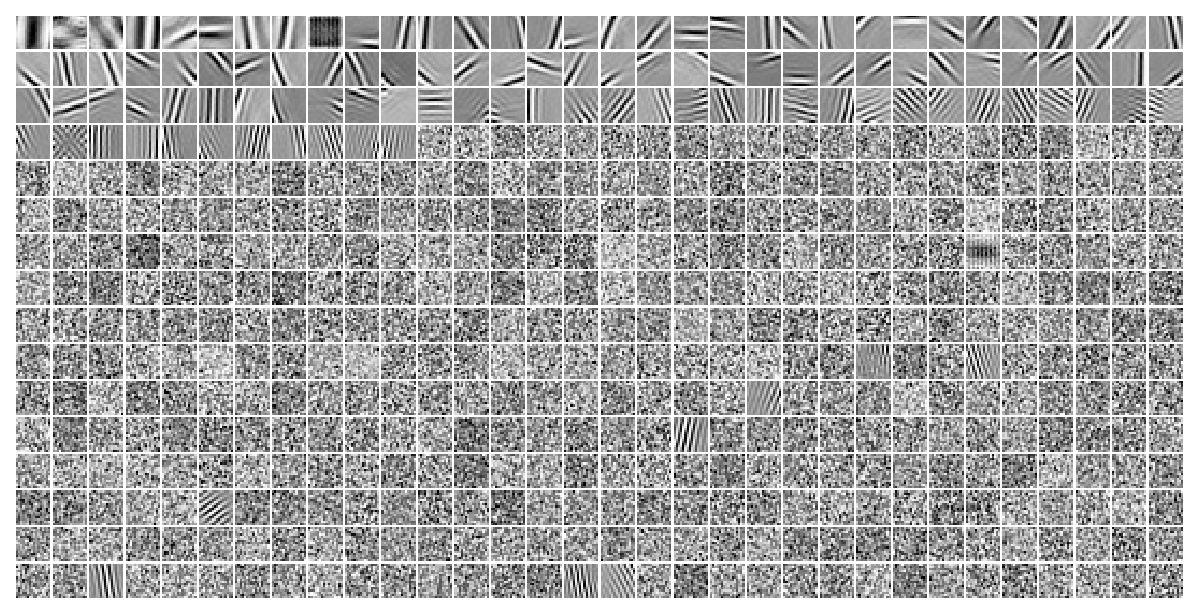

In [37]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show(order=order)

In [38]:
w_dec = tonp(tr.model.fc_dec.weight.data)
w_dec = w_dec.T.reshape(-1, 16, 16)
ids = np.argsort(results['sf_0'].values)

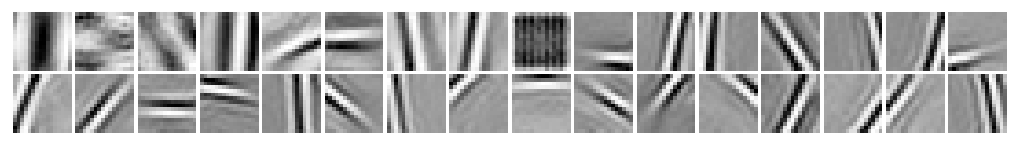

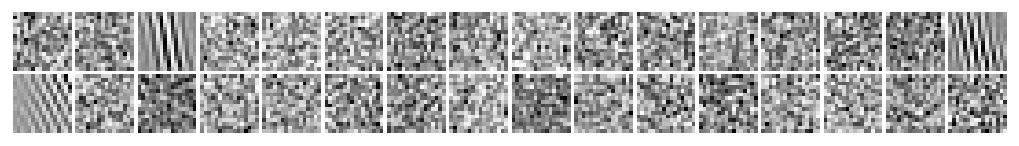

In [39]:
plot_weights(w_dec[ids[:32]], nrows=2, dpi=130)
plt.show()

plot_weights(w_dec[ids[-32:]], nrows=2, dpi=130)
plt.show()